# comma package tutorial

In [1]:
from comma.model import Model
from comma import create_empty_hypotheses
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
np.random.seed(0)
dir_params = '../parameters/'

### Step 1. Initialise the model


In [2]:
model = Model()

### Step 2. Generate 100 individuals by sampling from the IPF weights (previously computed in R)

Note that if you wish to generate a population based on parameters specified in `params_individual.json` simply set `use_ipf` to `False`. This will initiate a sampling from the distribution outlined in the json file, which does *not* take into account the joint probabilities within variables. Only the `use_ipf` set to `True` will sample with replacement from a distribution whereby the joint probabilities between variables is accounted for. 

In [3]:
size = 20
individuals = model.setup(size, '../parameters/', use_ipf=True) 

Populating individuals: 100%|█████████████████| 20/20 [00:00<00:00, 10483.14i/s]


### Step 3. Run the model

In [4]:
steps = 100

total = 100
n = total // 4
lockdown_pattern = ["absent"]*n + ["medium"]*n + ["hard"]*n + ["easy"]*n
model.run(steps=steps, lockdown=lockdown_pattern, out_path="simulation_results.csv")

Running simulation: 100%|█████████████████████| 100/100 [00:05<00:00, 17.18it/s]


The model at the end of the run will output "simulation_results.csv". 

### Step 4. Plot the results

In [5]:
data = pd.read_csv('simulation_results.csv', delimiter=";", decimal=",")

In [6]:
display(data.head())

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health
0,0,absent,0,0.0,0.002
1,0,absent,1,0.0,0.002
2,0,absent,2,0.0,0.003
3,0,absent,3,0.0,0.003
4,0,absent,4,0.0,0.003


#### Group by step_id and compute the average mental health score

In [20]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
grouped_data

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health
0,0,absent,9.5,0.00000,0.002000
1,1,absent,9.5,0.00230,0.002391
2,2,absent,9.5,0.00250,0.002836
3,3,absent,9.5,0.00225,0.003217
4,4,absent,9.5,0.00195,0.003336
...,...,...,...,...,...
95,95,easy,9.5,0.00185,-0.011538
96,96,easy,9.5,0.00215,-0.011348
97,97,easy,9.5,0.00235,-0.010899
98,98,easy,9.5,0.00225,-0.010603


### Create a scatter plot of the average mental health for each step coloured by lockdown type

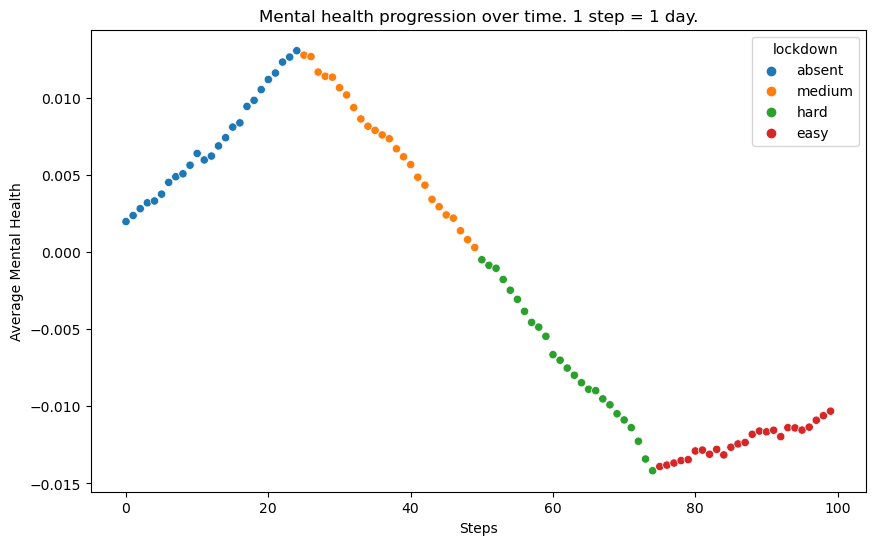

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='cumulative_mental_health', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Mental Health')
plt.title('Mental health progression over time. 1 step = 1 day.')
plt.show()